# Imports

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import json
import sys
from networkx.readwrite import json_graph

COLOR_BG = "#a8dadc"
COLOR_FG = "#457b9d"
SIZE_BG_NODES = 800
SIZE_FG_NODES = 2400
WEIGHT_BG_EDGES = 4
WEIGHT_FG_EDGES = 24
MATRIX_SIDE = 10
NO_FG_NODES = 20
FIG_SIZE = (12, 12)

# Graph creation

### Task 1 - create a 10x10 grid

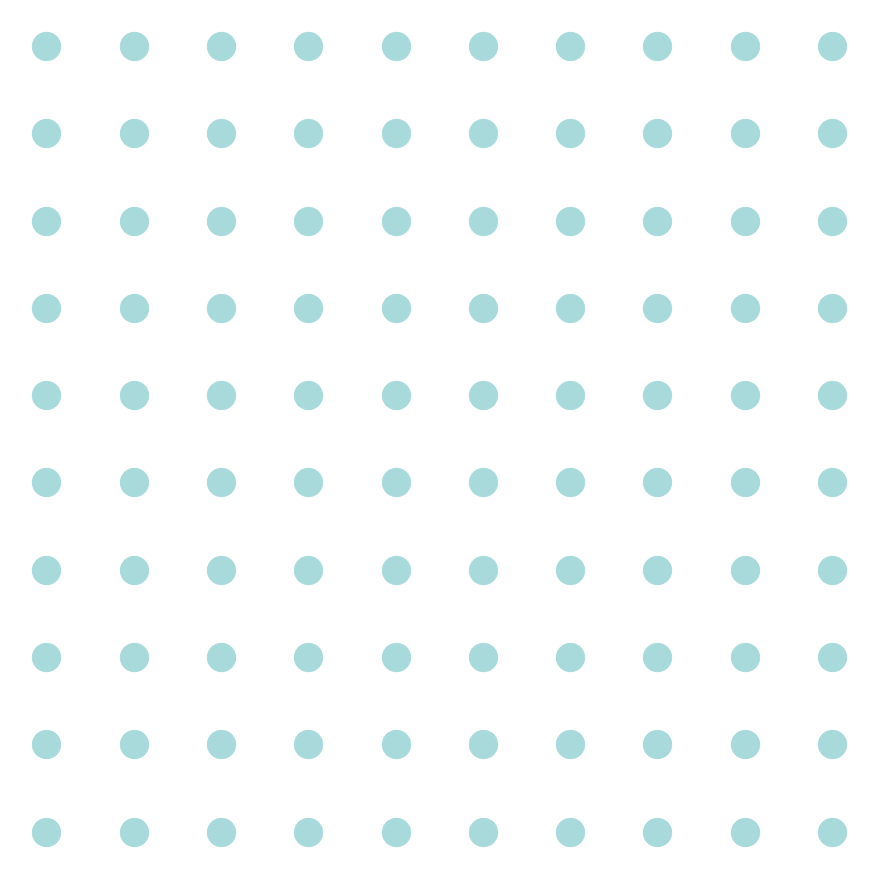

In [2]:
#first we create a 10x10 grid
G = nx.grid_2d_graph(MATRIX_SIDE, MATRIX_SIDE)
pos = {}
# the task requires us to use 2 nested loops
# we also assign positions to each node
for node in G.nodes():
    pos[node]=(node)
#allocate weights to the background edges
for edge in G.edges:
    G.edges[edge]['weight'] = WEIGHT_BG_EDGES
    
# removing all edges as required by the task
G.remove_edges_from(G.edges())
plt.figure(figsize=FIG_SIZE)
nx.draw(G, pos,node_color=COLOR_BG,edge_color=COLOR_BG,node_size=SIZE_BG_NODES)
plt.show()


### Task 2 - Randomly choose foreground nodes and take the rest as background nodes

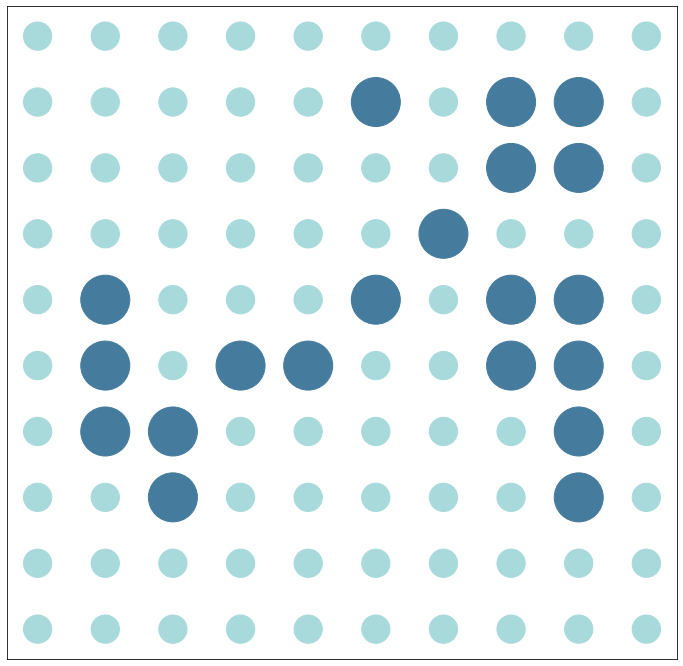

In [3]:
# we are randomly choosing a list of NO_FG_NODES background nodes from the matrix 
G = nx.grid_2d_graph(MATRIX_SIDE, MATRIX_SIDE)

# Now we get all the diagonal edges - suppose we take a node at random with
# coordinates (x,y), then its diagonal node will have coordinates (x+1,y+1)
# same reasoning applied for the node above it which will have coordinates  
# (x+1,y) and its diagonal node will have coordinates (x,y+1).
all_diagonal_edges= [((x, y), (x+1, y+1)) for x in range(MATRIX_SIDE-1) for y in range(MATRIX_SIDE-1)]\
                    +[((x+1, y), (x, y+1)) for x in range(MATRIX_SIDE-1) for y in range(MATRIX_SIDE-1)]

# add edges to all diagonals
G.add_edges_from(all_diagonal_edges, weight=WEIGHT_BG_EDGES)
# get all the foreground nodes - avoid using nodes on the borders
background_nodes = [i for i in G.nodes()]
possible_foreground_nodes = background_nodes.copy()
# remove all the border nodes from background_nodes to get the possible foreground nodes
for i in G.nodes():
    if any([i[0]==0, i[1]==0,i[0]==(MATRIX_SIDE-1),i[1]==(MATRIX_SIDE-1)]):
        possible_foreground_nodes.remove(i)
        
# choose randomly from possible foreground nodes "NO_FG_NODES" nodes as foreground nodes
# if we remove border nodes then for any (MATRIX_SIDE*MATRIX_SIDE) matrix we expect to get
num_of_possible_fg_nodes = (MATRIX_SIDE*MATRIX_SIDE)-((MATRIX_SIDE-1)*4)
if NO_FG_NODES <= num_of_possible_fg_nodes:
    foreground_nodes = random.sample(possible_foreground_nodes,NO_FG_NODES)    
else:
    # during testing when I tested very large values of "NO_FG_NODES" my code crashed
    # as sample size was greater then population, therefore if this happens I will take
    # all possible foreground nodes as foreground nodes which is given by 'num_of_possible_fg_nodes' 
    foreground_nodes = random.sample(possible_foreground_nodes,num_of_possible_fg_nodes)
    
background_nodes_after = [i for i in background_nodes if i not in foreground_nodes]
combined_node = background_nodes_after + foreground_nodes
# we can now specify the size and color of our nodes in the order we want them
combined_sizes = [SIZE_BG_NODES for i in background_nodes_after]+[SIZE_FG_NODES for j in foreground_nodes]
combined_colors = [COLOR_BG for i in background_nodes_after]+[COLOR_FG for j in foreground_nodes]

# having chosen a random sample of foreground nodes we take the rest of the nodes
# as background nodes(i.e background_nodes_after) then we find their edges
edges_of_bg_nodes = []
for node in background_nodes_after:
    neighbors = G.neighbors(node)
    for bg_node in neighbors:
        if bg_node not in foreground_nodes:
            edges_of_bg_nodes.append((node,bg_node))
            
# similarly we find the edges of our chosen foreground nodes 
edges_of_fg_nodes = []
for node in foreground_nodes:
    neighbors = G.neighbors(node)
    for fg_node in neighbors:
        if fg_node not in background_nodes_after:
            edges_of_fg_nodes.append((node,fg_node))

# since we cannot have any diagonal edges between our foreground nodes we 
# extract all the foreground edges that are not in the list of diagonal edges.            
for edge in edges_of_fg_nodes[:]:
    if edge in all_diagonal_edges:
        edges_of_fg_nodes.remove(edge)
    # we have to also cosider the nodes in reverse order to
    # remove rest of the diagonal edges between foreground nodes
    elif tuple(reversed(edge)) in all_diagonal_edges:
        edges_of_fg_nodes.remove(edge)

# we set background nodes attributes
for node in background_nodes_after:
    pos[node]=(node)
    G.nodes[node]["color"]= COLOR_BG
    G.nodes[node]["node_type"] = "bg"

# we set foreground nodes attributes
for node in foreground_nodes:
    pos[node]=(node)
    G.nodes[node]["color"]= COLOR_FG
    G.nodes[node]["node_type"] = "fg"

# we now set edge attributes for background edges
edge_weights = []        
for edge in edges_of_bg_nodes:
    G.edges[edge]['weight'] = WEIGHT_BG_EDGES
    edge_weights.append(WEIGHT_BG_EDGES)
    G.edges[edge]['color'] = COLOR_BG

# set edge attributes of foreground edges  
for edge in edges_of_fg_nodes:
    G.edges[edge]['weight'] = WEIGHT_FG_EDGES 
    edge_weights.append(WEIGHT_FG_EDGES)
    G.edges[edge]['color'] = COLOR_FG

#here we combine both edges and their colors in the correct order
combined_edges = edges_of_bg_nodes + edges_of_fg_nodes
combined_edge_colors = [COLOR_BG for i in edges_of_bg_nodes]+[COLOR_FG for j in edges_of_fg_nodes]

plt.figure(figsize=FIG_SIZE)
nx.draw_networkx_nodes(G, pos,nodelist=combined_node, 
                       node_size=combined_sizes,node_color=combined_colors)

plt.show()

### Task 3 - Join nodes such that foreground nodes and background nodes connect within themselves

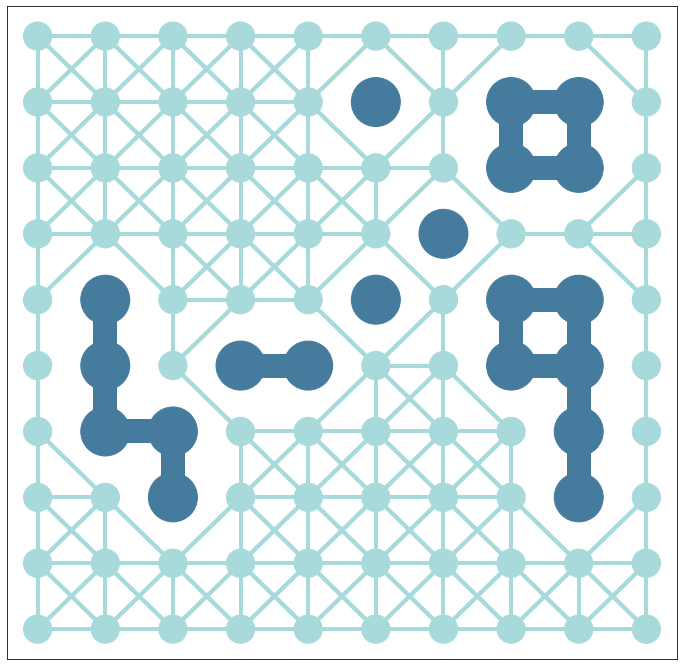

In [4]:
# for this task I am adding all the edges to my graph plot with foreground
# nodes that have been chosen randomly in task 2. repeated run of this cell
# will produce the same output. if you want to choose different foreground nodes
# then you will have to run task 2 code again as it has the random.sample() method.
plt.figure(figsize=FIG_SIZE)
nx.draw_networkx_edges(G, pos, width=edge_weights, edgelist=combined_edges,edge_color=combined_edge_colors)
nx.draw_networkx_nodes(G, pos,nodelist=combined_node, node_size=combined_sizes,node_color=combined_colors)
plt.show()

# Graph manipulation and output

### Task 4 - extract data from the network graph

In [5]:
graph_info = nx.info(G)
graph_density = nx.density(G)
degree_centrality_of_nodes = nx.degree_centrality(G)

print("Graph Information")
print(graph_info)
print()
print("-"*50)
print(f"The density of the graph is: {graph_density}")
print()
print("-"*50)
print("The degree centrality of the nodes are:")
print()
print(degree_centrality_of_nodes)

Graph Information
Name: 
Type: Graph
Number of nodes: 100
Number of edges: 342
Average degree:   6.8400

--------------------------------------------------
The density of the graph is: 0.06909090909090909

--------------------------------------------------
The degree centrality of the nodes are:

{(0, 0): 0.030303030303030304, (0, 1): 0.05050505050505051, (0, 2): 0.05050505050505051, (0, 3): 0.05050505050505051, (0, 4): 0.05050505050505051, (0, 5): 0.05050505050505051, (0, 6): 0.05050505050505051, (0, 7): 0.05050505050505051, (0, 8): 0.05050505050505051, (0, 9): 0.030303030303030304, (1, 0): 0.05050505050505051, (1, 1): 0.08080808080808081, (1, 2): 0.08080808080808081, (1, 3): 0.08080808080808081, (1, 4): 0.08080808080808081, (1, 5): 0.08080808080808081, (1, 6): 0.08080808080808081, (1, 7): 0.08080808080808081, (1, 8): 0.08080808080808081, (1, 9): 0.05050505050505051, (2, 0): 0.05050505050505051, (2, 1): 0.08080808080808081, (2, 2): 0.08080808080808081, (2, 3): 0.08080808080808081, (2,

### Task 5 - Export the network data as a json file

In [6]:
graph_in_json = json_graph.node_link_data(G)

# organising JSON output
for dict_item in graph_in_json["nodes"]:
    dict_item["id"] = str(f"{dict_item['id'][0]}-{dict_item['id'][1]}")  
    
for dict_item in graph_in_json["links"]:
    dict_item["source"]=str(f"{dict_item['source'][0]}-{dict_item['source'][1]}")
    dict_item["target"]=str(f"{dict_item['target'][0]}-{dict_item['target'][1]}")

# here I am exporting the graph data into a JSON file called "graph_data.json"
# you can find the file by searching "graph_data.json" on windows search bar
with open('graph_data.json', 'w') as outfile:
    json.dump(graph_in_json, outfile,indent=2)
    
# I will also print the json data here as well
print(json.dumps(graph_in_json,indent=2))

{
  "directed": false,
  "multigraph": false,
  "graph": {},
  "nodes": [
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-0"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-1"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-2"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-3"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-4"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-5"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-6"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-7"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-8"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "0-9"
    },
    {
      "color": "#a8dadc",
      "node_type": "bg",
      "id": "1-0"
    },
    {
      "color": "#a